In [38]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import FiniteDiff
import ForwardDiff as FD
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
using MeshCat
const mc = MeshCat
using StaticArrays
using Printf

  Activating environment at `C:\Users\hilld\Documents\git\ocrl\ocrl_quadruped_mpc\Project.toml`


## Dynamics

In [39]:
function skew_symmetric(r::Vector) #function to convert vector to cross-product skew-symmetric matrix
    R = [0 -r[3] r[2]; r[3] 0 -r[1]; -r[2] r[1] 0]
    return R
end

function R_z(sigma::Real)
     R = [cos(sigma) sin(sigma) 0; -sin(sigma) cos(sigma) 0; 0 0 1]
    return R
end

#dynamics function of quadruped
function dynamics(model::NamedTuple, x::Vector, u::Vector, r1::Vector, r2::Vector, r3::Vector, r4::Vector)
    #state is defined as [x,theta,x_dot,theta_dot]^T
    #force is defined as [fl,fr,bl,br]^T where each one is composed of x,y,z forces
    
    m, J = model.m, model.J

    A = vcat(hcat(zeros(6,6), vcat(hcat(R_z(x[6]),zeros(3,3)),hcat(zeros(3,3),Matrix{Float64}(I,3,3)))), zeros(6,12)) #A matrix
    #B1 is first 9 rows of B matrix, first 6 rows are zeros, next rows are F = ma
    B1 = vcat(zeros(6,12), 1/m * hcat(hcat(Matrix{Float64}(I,3,3),Matrix{Float64}(I,3,3)),hcat(Matrix{Float64}(I,3,3),Matrix{Float64}(I,3,3))))
    #B2 is last 3 rows of B matrix effecting theta_dot, these are tau = J*theta_dot
    B2 = hcat(hcat(J \ skew_symmetric(r1 - x[1:3]), J \ skew_symmetric(r2 - x[1:3])),hcat(J \ skew_symmetric(r3 - x[1:3]), J \ skew_symmetric(r4 - x[1:3])))
    B = vcat(B1,B2) #add B1 to B2 to get full B matrix
    C = vcat(vcat(zeros(8),1),zeros(3)) #gravity term    
    
    Ag = vcat(hcat(A,C),zeros(1,13))
    Bg = vcat(B,zeros(1,12))
    
    x_dot = Ag * x + Bg * u #calculate x_dot (full state derivative)
    
#     @show Ag
#     @show Ag * x
#     @show Bg
#     @show Bg * u
    
    return x_dot
end

#rk4 function for discritization of dynamics
function rk4(model::NamedTuple, ode::Function, x::Vector, u::Vector, r1::Vector, r2::Vector, r3::Vector, r4::Vector, dt::Real)::Vector
    k1 = dt * ode(model, x,        u, r1, r2, r3, r4)
    k2 = dt * ode(model, x + k1/2, u, r1, r2, r3, r4)
    k3 = dt * ode(model, x + k2/2, u, r1, r2, r3, r4)
    k4 = dt * ode(model, x + k3,   u, r1, r2, r3, r4)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end


rk4 (generic function with 1 method)

## Reference Trajectory and Gait Planner

In [46]:
function circular_reference_trajectory(model, radius, dt, gait_period, num_gaits)
    # creates a reference Xref and Uref for walker
    
    l, w, m, g = model.l, model.w, model.m, model.g
    
    N = Int(num_gaits * gait_period / dt + 2) #define N
    
    half_gait = Int(gait_period / (2 * dt))     #number of time steps in half a gait period
    quarter_gait = Int(gait_period / (4 * dt))  #number of time steps in a quarter of a gait period
    
    fl_s = zeros(N) #initialize fl_s etc. These are the gait timings
    fl_s[1] = 1
    fl_s[N] = 1
    fr_s = zeros(N)
    fr_s[1] = 1
    fr_s[N] = 1
    bl_s = zeros(N)
    bl_s[1] = 1    
    bl_s[N] = 1
    br_s = zeros(N)
    br_s[1] = 1
    br_s[N] = 1
    
    #diagonal trot gait
#     state = 0
#     for i = 2:half_gait:N-1  #every quarter gait, switch feet
#         if(state == 0)
#             fl_s[i:i+half_gait-1] = zeros(half_gait)
#             fr_s[i:i+half_gait-1] = ones(half_gait)
#             bl_s[i:i+half_gait-1] = ones(half_gait)
#             br_s[i:i+half_gait-1] = zeros(half_gait)
#             state = 1
#         elseif(state == 1)
#             fl_s[i:i+half_gait-1] = ones(half_gait)
#             fr_s[i:i+half_gait-1] = zeros(half_gait)
#             bl_s[i:i+half_gait-1] = zeros(half_gait)
#             br_s[i:i+half_gait-1] = ones(half_gait)
#             state = 0
#         end
#     end
    
    #bear walk gait
    state = 0
    for i = 2:quarter_gait:N-1  #every quarter gait, switch feet
        if(state == 0)
            fl_s[i:i+quarter_gait-1] = zeros(quarter_gait)
            fr_s[i:i+quarter_gait-1] = ones(quarter_gait)
            bl_s[i:i+quarter_gait-1] = ones(quarter_gait)
            br_s[i:i+quarter_gait-1] = ones(quarter_gait)
            state = 1
        elseif(state == 1)
            fl_s[i:i+quarter_gait-1] = ones(quarter_gait)
            fr_s[i:i+quarter_gait-1] = ones(quarter_gait)
            bl_s[i:i+quarter_gait-1] = ones(quarter_gait)
            br_s[i:i+quarter_gait-1] = zeros(quarter_gait)
            state = 2
        elseif(state == 2)
            fl_s[i:i+quarter_gait-1] = ones(quarter_gait)
            fr_s[i:i+quarter_gait-1] = zeros(quarter_gait)
            bl_s[i:i+quarter_gait-1] = ones(quarter_gait)
            br_s[i:i+quarter_gait-1] = ones(quarter_gait)
            state = 3
        elseif(state == 3)
            fl_s[i:i+quarter_gait-1] = ones(quarter_gait)
            fr_s[i:i+quarter_gait-1] = ones(quarter_gait)
            bl_s[i:i+quarter_gait-1] = zeros(quarter_gait)
            br_s[i:i+quarter_gait-1] = ones(quarter_gait)
            state = 0
        end
    end
    
#     @show fl_s
#     @show fr_s
#     @show bl_s
#     @show br_s
    
    Xref = [zeros(13) for i = 1:N] #initialize state reference trajectory
    v = [zeros(2) for i = 1:N]
    for i = 1:N
        v[i][1] = radius*cos(2 * pi * i / N)
        v[i][2] = radius*sin(2 * pi * i / N)
    end
#     v = (xg[3] - xic[3]) / ((N-1) * dt) #assuming straight line path, get constant velocity required
    
    for i = 1:N #fill in state reference trajectory
        Xref[i] = [radius*sin(2 * pi * i / N), -radius*cos(2 * pi * i / N), 0, 0, 0, 2 * pi * i / N, v[i][1], v[i][2],0,0,0,0,g]
    end
    
#     Uref = [zeros(12) for i = 1:N-1] #initialize state reference trajectory
    
#     for i = 1:N-1
#         count = fl_s[i] + fr_s[i] + bl_s[i] + br_s[i]
#         Uref[i][3] = fl_s[i] * -m*g / count
#         Uref[i][6] = fr_s[i] * -m*g / count
#         Uref[i][9] = bl_s[i] * -m*g / count
#         Uref[i][12] = br_s[i] * -m*g / count
#     end
    
    r1 = [zeros(3) for i=1:N] #initialize r vectors
    r2 = [zeros(3) for i=1:N]
    r3 = [zeros(3) for i=1:N]
    r4 = [zeros(3) for i=1:N]
    
    r1[1] = [l/2 + Xref[1][1], w/2 + Xref[1][2], 0] #start standing up straight
    r2[1] = [l/2 + Xref[1][1], -w/2 + Xref[1][2], 0]
    r3[1] = [-l/2 + Xref[1][1], w/2 + Xref[1][2], 0]
    r4[1] = [-l/2 + Xref[1][1], -w/2 + Xref[1][2], 0]
    
    r1[N] = [l/2 + Xref[N][1], w/2 + Xref[N][2], 0] #end standing up straight
    r2[N] = [l/2 + Xref[N][1], -w/2 + Xref[N][2], 0]
    r3[N] = [-l/2 + Xref[N][1], w/2 + Xref[N][2], 0]
    r4[N] = [-l/2 + Xref[N][1], -w/2 + Xref[N][2], 0]
    
    for i = 2:N-1 #for each sequential half gait, set legs reaching past shoulders to start
        r1[i] = r1[i-1]
        r2[i] = r2[i-1]
        r3[i] = r3[i-1]
        r4[i] = r4[i-1]
        if((fl_s[i-1] == 0) & (fl_s[i] == 1))
            r1[i] = [l/2 + Xref[i][1] + gait_period/2 *v[i][1], w/2 + Xref[i][2] + gait_period/2 * v[i][2], 0]
        end
        if((fr_s[i-1] == 0) & (fr_s[i] == 1))
            r2[i] = [l/2 + Xref[i][1] + gait_period/2 * v[i][1], -w/2 + Xref[i][2] + gait_period/2 * v[i][2], 0]
        end
        if((bl_s[i-1] == 0) & (bl_s[i] == 1))
            r3[i] = [-l/2 + Xref[i][1] + gait_period/2 * v[i][1], w/2 + Xref[i][2] + gait_period/2 * v[i][2], 0]
        end
        if((br_s[i-1] == 0) & (br_s[i] == 1))
            r4[i] = [-l/2 + Xref[i][1] + gait_period/2 * v[i][1], -w/2 + Xref[i][2] + gait_period/2 * v[i][2], 0]
        end
    end
        
    return Xref, N, fl_s, fr_s, bl_s, br_s, r1, r2, r3, r4
end

circular_reference_trajectory (generic function with 1 method)

In [59]:
function reference_trajectory(model, xic, xg, dt, gait_period, num_gaits)
    # creates a reference Xref and Uref for walker
    
    l, w, m, g = model.l, model.w, model.m, model.g
    
    N = Int(num_gaits * gait_period / dt + 2) #define N
    
    half_gait = Int(gait_period / (2 * dt))     #number of time steps in half a gait period
    quarter_gait = Int(gait_period / (4 * dt))  #number of time steps in a quarter of a gait period
    
    fl_s = zeros(N) #initialize fl_s etc. These are the gait timings
    fl_s[1] = 1
    fl_s[N] = 1
    fr_s = zeros(N)
    fr_s[1] = 1
    fr_s[N] = 1
    bl_s = zeros(N)
    bl_s[1] = 1    
    bl_s[N] = 1
    br_s = zeros(N)
    br_s[1] = 1
    br_s[N] = 1
    
    #diagonal trot gait
    state = 0
    for i = 2:half_gait:N-1  #every quarter gait, switch feet
        if(state == 0)
            fl_s[i:i+half_gait-1] = zeros(half_gait)
            fr_s[i:i+half_gait-1] = ones(half_gait)
            bl_s[i:i+half_gait-1] = ones(half_gait)
            br_s[i:i+half_gait-1] = zeros(half_gait)
            state = 1
        elseif(state == 1)
            fl_s[i:i+half_gait-1] = ones(half_gait)
            fr_s[i:i+half_gait-1] = zeros(half_gait)
            bl_s[i:i+half_gait-1] = zeros(half_gait)
            br_s[i:i+half_gait-1] = ones(half_gait)
            state = 0
        end
    end
    
    #bear walk gait
#     state = 0
#     for i = 2:quarter_gait:N-1  #every quarter gait, switch feet
#         if(state == 0)
#             fl_s[i:i+quarter_gait-1] = zeros(quarter_gait)
#             fr_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             bl_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             br_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             state = 1
#         elseif(state == 1)
#             fl_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             fr_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             bl_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             br_s[i:i+quarter_gait-1] = zeros(quarter_gait)
#             state = 2
#         elseif(state == 2)
#             fl_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             fr_s[i:i+quarter_gait-1] = zeros(quarter_gait)
#             bl_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             br_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             state = 3
#         elseif(state == 3)
#             fl_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             fr_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             bl_s[i:i+quarter_gait-1] = zeros(quarter_gait)
#             br_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             state = 0
#         end
#     end
    
#     @show fl_s
#     @show fr_s
#     @show bl_s
#     @show br_s
    
    Xref = [zeros(13) for i = 1:N] #initialize state reference trajectory
    
    v = (xg[3] - xic[3]) / ((N-1) * dt) #assuming straight line path, get constant velocity required
    
    points, yaw_angles = semicircular_arc((xic[1], xic[2]), (xg[1], xg[2]), N)
    x_coords = [point[1] for point in points]
    y_coords = [point[2] for point in points]   
    
    # circle 
    for i = 1:N
        Xref[i] = [x_coords[i], y_coords[i], model.h, 0, 0, yaw_angles[i], 0, 0, 0, 0, 0, 0, g]
    end



    # for i = 1:N #fill in state reference trajectory
    #     Xref[i] = vcat(((N-i) * xic[1:6] + (i-1) * xg[1:6]) / (N-1), [v,0,0,0,0,0,g])
    # end
    
#     Uref = [zeros(12) for i = 1:N-1] #initialize state reference trajectory
    
#     for i = 1:N-1
#         count = fl_s[i] + fr_s[i] + bl_s[i] + br_s[i]
#         Uref[i][3] = fl_s[i] * -m*g / count
#         Uref[i][6] = fr_s[i] * -m*g / count
#         Uref[i][9] = bl_s[i] * -m*g / count
#         Uref[i][12] = br_s[i] * -m*g / count
#     end
    
    r1 = [zeros(3) for i=1:N] #initialize r vectors
    r2 = [zeros(3) for i=1:N]
    r3 = [zeros(3) for i=1:N]
    r4 = [zeros(3) for i=1:N]
    
    r1[1] = [l/2 + Xref[1][1], w/2 + Xref[1][2], 0] #start standing up straight
    r2[1] = [l/2 + Xref[1][1], -w/2 + Xref[1][2], 0]
    r3[1] = [-l/2 + Xref[1][1], w/2 + Xref[1][2], 0]
    r4[1] = [-l/2 + Xref[1][1], -w/2 + Xref[1][2], 0]
    
    r1[N] = [l/2 + Xref[N][1], w/2 + Xref[N][2], 0] #end standing up straight
    r2[N] = [l/2 + Xref[N][1], -w/2 + Xref[N][2], 0]
    r3[N] = [-l/2 + Xref[N][1], w/2 + Xref[N][2], 0]
    r4[N] = [-l/2 + Xref[N][1], -w/2 + Xref[N][2], 0]
    
    for i = 2:N-1 #for each sequential half gait, set legs reaching past shoulders to start
        r1[i] = r1[i-1]
        r2[i] = r2[i-1]
        r3[i] = r3[i-1]
        r4[i] = r4[i-1]
        if((fl_s[i-1] == 0) & (fl_s[i] == 1))
            r1[i] = [l/2 + Xref[i][1] + gait_period/2 * v, w/2 + Xref[i][2], 0]
        end
        if((fr_s[i-1] == 0) & (fr_s[i] == 1))
            r2[i] = [l/2 + Xref[i][1] + gait_period/2 * v, -w/2 + Xref[i][2], 0]
        end
        if((bl_s[i-1] == 0) & (bl_s[i] == 1))
            r3[i] = [-l/2 + Xref[i][1] + gait_period/2 * v, w/2 + Xref[i][2], 0]
        end
        if((br_s[i-1] == 0) & (br_s[i] == 1))
            r4[i] = [-l/2 + Xref[i][1] + gait_period/2 * v, -w/2 + Xref[i][2], 0]
        end
    end
        
    return Xref, N, fl_s, fr_s, bl_s, br_s, r1, r2, r3, r4
end

reference_trajectory (generic function with 1 method)

## Test Dynamics and Gait Planner

Xref[1] = [0.0, 0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -9.81]
Uref[1] = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
fl_s[1] = 1.0
fr_s[1] = 1.0
bl_s[1] = 1.0
br_s[1] = 1.0
r1[1] = [0.5, 0.2, 0.0]
r2[1] = [0.5, -0.2, 0.0]
r3[1] = [-0.5, 0.2, 0.0]
r4[1] = [-0.5, -0.2, 0.0]
x_dot = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -9.81, 0.0, 0.0, 0.0, 0.0]


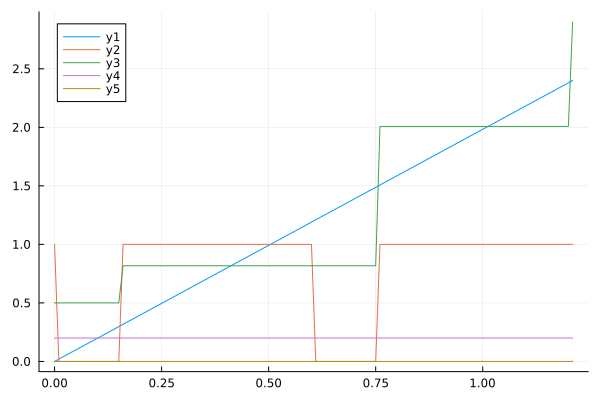

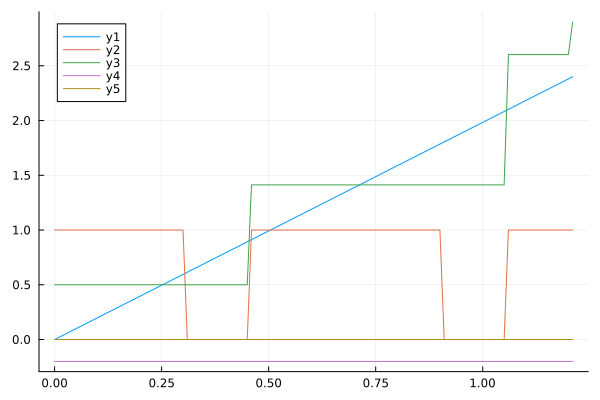

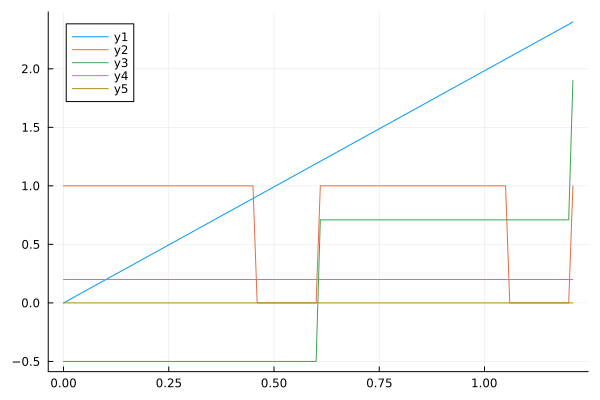

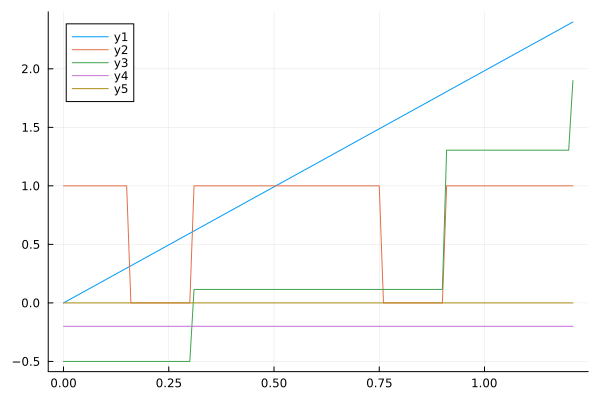

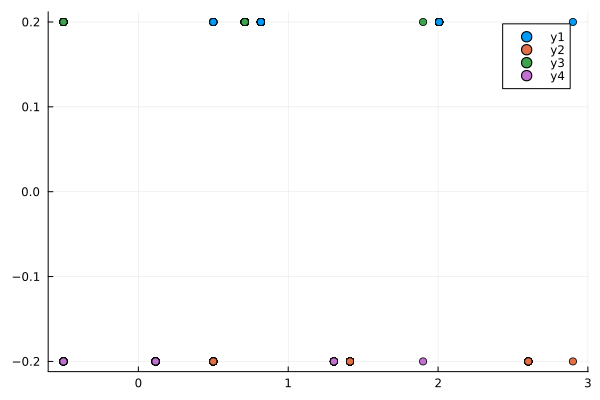

In [35]:
#model defined here
model = (g = -9.81, m = 5.0, J = diagm([1,5.2,5.8]), l = 1.0, w = 0.4, h = 0.6, mu = 0.5)
v = 2
dt = 0.01
gait_period = 0.6
num_gaits = 2
xic = [0,0,model.h,0,0,0,0,0,0,0,0,0]
xg = [v*gait_period*num_gaits,0,model.h,0,0,0,0,0,0,0,0,0]

tf = N * dt 
t_vec = 0:dt:tf

#construct reference trajectory
Xref, N, fl_s, fr_s, bl_s, br_s, r1, r2, r3, r4 = reference_trajectory(model, xic, xg, dt, gait_period, num_gaits)

# Uref = [zeros(12) for i=1:N-1]

@show Xref[1]
@show Uref[1]
@show fl_s[1]
@show fr_s[1]
@show bl_s[1]
@show br_s[1]
@show r1[1]
@show r2[1]
@show r3[1]
@show r4[1]

x_dot = dynamics(model, Xref[1], Uref[1], r1[1], r2[1], r3[1], r4[1])

@show x_dot

# # calculate Jacobians
# As = [zeros(nx,nx) for i = 1:N-1]
# Bs = [zeros(nx,nu) for i = 1:N-1]
# for i = 1:N-1
#     As[i] = FD.jacobian(x -> rk4(model, dynamics, x, Uref[i], r1[i], r2[i], r3[i], r4[i], dt), Xref[i])
#     Bs[i] = FD.jacobian(u -> rk4(model, dynamics, Xref[i], u, r1[i], r2[i], r3[i], r4[i], dt), Uref[i])
# end
# #this C is our gravity term (not sure if this is done correctly)
# C = rk4(model, dynamics, zeros(12), zeros(12), r1[1], r2[1], r3[1], r4[1], dt)

# Xsim = [zeros(12) for i = 1:N]
# Xsim[1] = Xref[1]

# for i = 1:N-1
#     Xsim[i+1] = rk4(model, dynamics, Xsim[i], U[i], r1[i], r2[i], r3[i], r4[i], dt)
# end

# Xsim = hcat(Xsim...)

# display(plot(t_vec[1:end-1], Xsim[1:3,:]', lc = [:red :green :blue]))

# display(plot(t_vec[1:end-1], Xsim[4:6,:]', lc = [:red :green :blue]))
# plot(t_vec[1:end-1], fl_s)
# plot!(t_vec[1:end-1], fr_s)
# plot!(t_vec[1:end-1], bl_s)
# display(plot!(t_vec[1:end-1], br_s))
    
r1 = hcat(r1...)
r2 = hcat(r2...)
r3 = hcat(r3...)
r4 = hcat(r4...)
Xref = hcat(Xref...)

plot(t_vec[1:end-1], Xref[1,:])
plot!(t_vec[1:end-1], fl_s)
display(plot!(t_vec[1:end-1], r1[1:3,:]'))

plot(t_vec[1:end-1], Xref[1,:])
plot!(t_vec[1:end-1], fr_s)
display(plot!(t_vec[1:end-1], r2[1:3,:]'))
    
plot(t_vec[1:end-1], Xref[1,:])
plot!(t_vec[1:end-1], bl_s)
display(plot!(t_vec[1:end-1], r3[1:3,:]'))

plot(t_vec[1:end-1], Xref[1,:])
plot!(t_vec[1:end-1], br_s)
display(plot!(t_vec[1:end-1], r4[1:3,:]'))

scatter(r1[1,:], r1[2,:], mode="markers")
scatter!(r2[1,:], r2[2,:], mode="markers")
scatter!(r3[1,:], r3[2,:], mode="markers")
display(scatter!(r4[1,:], r4[2,:], mode="markers"))
    
# plot(t_vec[1:end-2], Urefm[1:3,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls FL")
# display(plot!(t_vec[1:end-2], Um[1:3,:]', lc = [:red :green :blue]))
#     plot(t_vec[1:end-2], Urefm[4:6,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls FR")
# display(plot!(t_vec[1:end-2], Um[4:6,:]', lc = [:red :green :blue]))
# plot(t_vec[1:end-2], Urefm[7:9,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls BL")
# display(plot!(t_vec[1:end-2], Um[7:9,:]', lc = [:red :green :blue]))
# plot(t_vec[1:end-2], Urefm[10:12,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls BR")
# display(plot!(t_vec[1:end-2], Um[10:12,:]', lc = [:red :green :blue]))

## Solve


ECOS 2.0.8 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+000  -9.609e+004  +4e+005  2e-001  4e-001  1e+000  9e+001    ---    ---    1  2  - |  -  - 
 1  +2.691e+002  -1.003e+005  +4e+005  2e-001  2e-002  4e+000  9e+001  0.0323  1e+000   2  2  1 |  0  0
 2  +2.273e+002  -1.012e+005  +4e+005  2e-001  2e-002  7e+000  9e+001  0.0334  9e-001   1  1  1 |  0  0
 3  +2.091e+002  -6.522e+004  +3e+005  1e-001  9e-003  3e+001  6e+001  0.5909  4e-001   2  2  1 |  0  0
 4  +8.500e+001  -2.654e+004  +1e+005  6e-002  4e-003  1e+001  3e+001  0.5218  3e-002   2  2  2 |  0  0
 5  +1.578e+002  -9.331e+003  +5e+004  2e-002  5e-003  1e+001  1e+001  0.9890  4e-001   2  2  1 |  0  0
 6  +1.636e+002  -6.791e+003  +3e+004  1e-002  2e-003  7e+000  8e+000  0.5433  5e-001   1  1  1 |  0  0
 7  +1.702e+002  -5.983e+003  +3e+004  1e-002  6e-004  7e+000  7e+000  0.3141  5e-001  

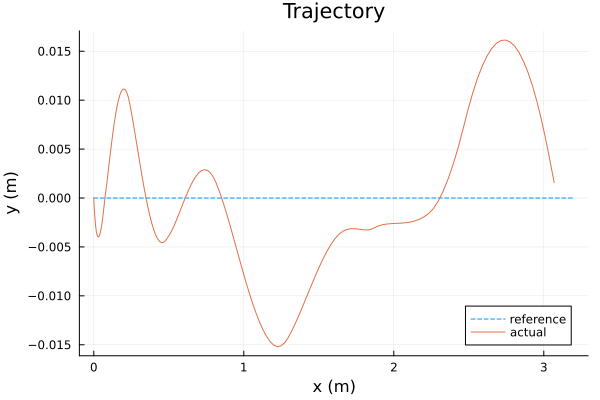

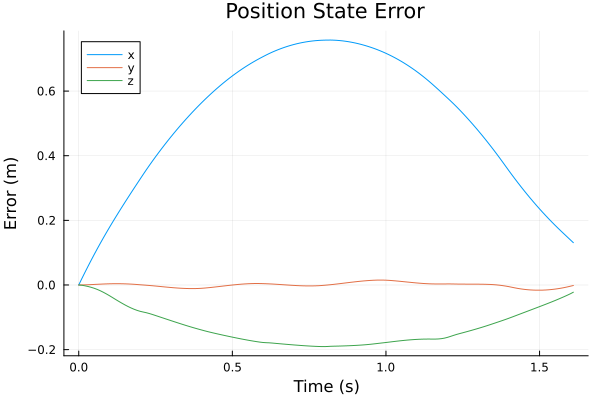

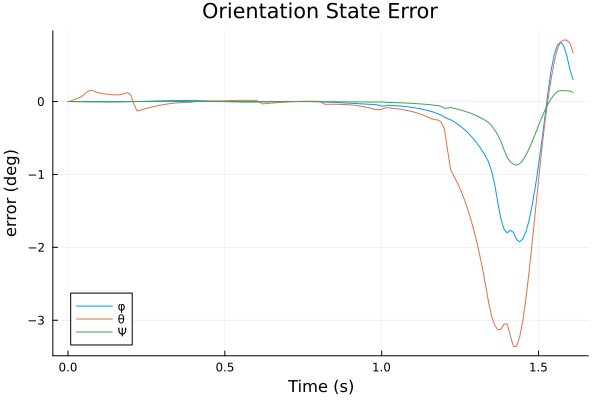

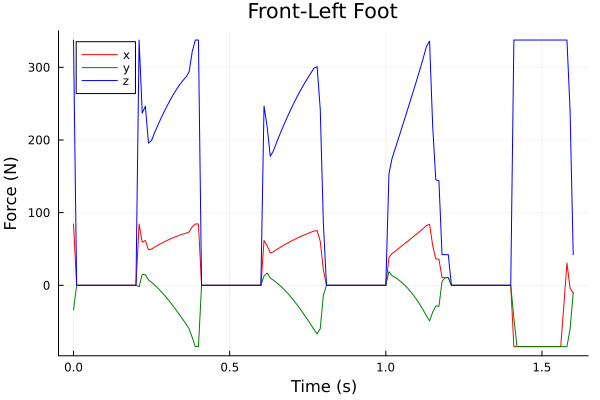

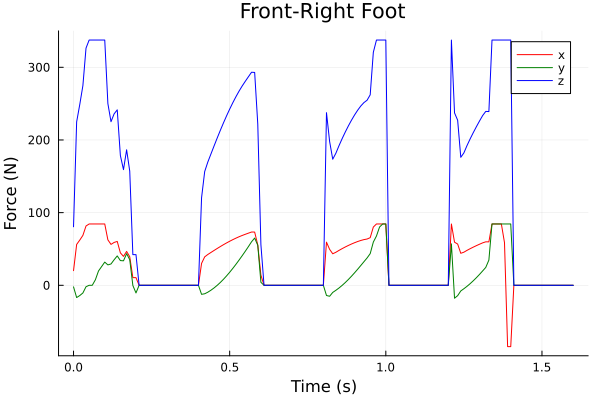

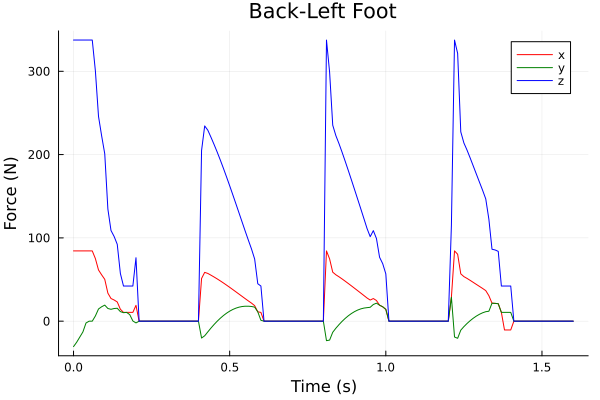

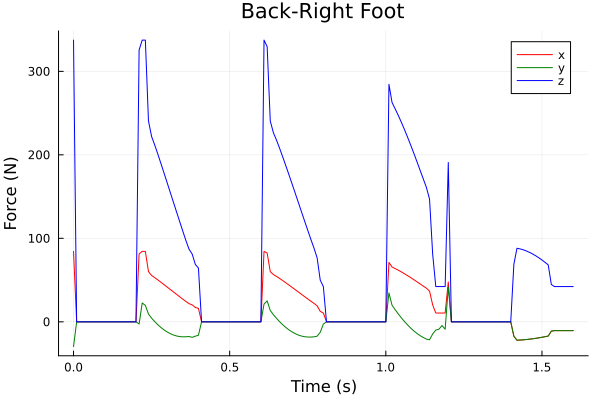

In [67]:
function vec_from_mat(Xm::Matrix)::Vector{Vector{Float64}}
    # convert a matrix into a vector of vectors 
    X = [Xm[:,i] for i = 1:size(Xm,2)]
    return X 
end

#model defined here
model = (g = -9.81, m = 43.0, J = diagm([0.41,2.1,2.1]), l = 0.8, w = 0.3, h = 0.4, mu = 0.25)
v = 2
dt = 0.01
gait_period = 0.4
num_gaits = 4
xic = [0,0,model.h,0,0,0,0,0,0,0,0,0]
xg = [v*gait_period*num_gaits,0,model.h,0,0,0,0,0,0,0,0,0]

#construct reference trajectory
Xref, N, fl_s, fr_s, bl_s, br_s, r1, r2, r3, r4 = reference_trajectory(model, xic, xg, dt, gait_period, num_gaits)

# N = 50

Uref = [zeros(12) for i=1:N-1]

# @show r1
# @show r2
# @show r3
# @show r4

tf = N * dt 
t_vec = 0:dt:tf 

nx = 12
nu = 12

# LQR tracking cost to be used in ILC 
Q = diagm([100,100,100,100,100,100,1,1,1,1,1,1,0])
R = 0*diagm(ones(nu))
Qf = 100*Q
            
# calculate Jacobians
As = [zeros(nx,nx) for i = 1:N-1]
Bs = [zeros(nx,nu) for i = 1:N-1]
for i = 1:N-1
    As[i] = FD.jacobian(x -> rk4(model, dynamics, x, Uref[i], r1[i], r2[i], r3[i], r4[i], dt), Xref[i])
    Bs[i] = FD.jacobian(u -> rk4(model, dynamics, Xref[i], u, r1[i], r2[i], r3[i], r4[i], dt), Uref[i])
end

# @show As[6]
# @show As[7]
# @show Bs[6]
# @show Bs[7]

# create variables 
X = cvx.Variable(nx+1, N) #add extra state dimension for gravity
U = cvx.Variable(nu, N-1)

# cost function (tracking cost on Xref, Uref)
cost = 0.0
for k = 1:N-1
    # add stagewise cost 
    cost += 0.5*cvx.quadform(X[:,k] - Xref[k],Q) + 0.5*cvx.quadform(U[:,k],R)
end

cost += 0.5*cvx.quadform(X[:,N] - Xref[N],Qf)

# problem instance
prob = cvx.minimize(cost)

# initial condition constraint
prob.constraints += (X[:,1] == Xref[1])

# final condition constraint
# prob.constraints += (X[:,N] == Xref[N])

# dynamics constraints
for k = 1:(N-1)
    prob.constraints += (X[:,k+1] == As[k]*X[:,k] + Bs[k]*U[:,k])
end

#height constraint (no limbo)
# for k = 1:N
#     prob.constraints += (X[3,k] > model.h * 0.9)
#     prob.constraints += (X[3,k] < model.h * 1.1)
# end

# gait constraints (only able to use feet when the are on the ground)
for k = 1:N-1
    if fl_s[k] == 0
        prob.constraints += (U[3,k] == 0)
    else
        prob.constraints += (U[3,k] >= -model.m*model.g*0.1)  
        prob.constraints += (U[3,k] <= -model.m*model.g*0.8)        
    end
    if fr_s[k] == 0
        prob.constraints += (U[6,k] == 0)
    else
        prob.constraints += (U[6,k] >= -model.m*model.g*0.1)
        prob.constraints += (U[6,k] <= -model.m*model.g*0.8)   
    end
    if bl_s[k] == 0
        prob.constraints += (U[9,k] == 0)
    else
        prob.constraints += (U[9,k] >= -model.m*model.g*0.1) 
        prob.constraints += (U[9,k] <= -model.m*model.g*0.8)  
    end
    if br_s[k] == 0
        prob.constraints += (U[12,k] == 0)
    else
        prob.constraints += (U[12,k] >= -model.m*model.g*0.1) 
        prob.constraints += (U[12,k] <= -model.m*model.g*0.8)  
    end
end

#friction constraints (friction cone)
for k = 1:N-1
    #front left
    prob.constraints += (U[1,k] <= model.mu * U[3,k])
    prob.constraints += (U[1,k] >= -model.mu * U[3,k])
    prob.constraints += (U[2,k] <= model.mu * U[3,k])
    prob.constraints += (U[2,k] >= -model.mu * U[3,k])
    #front right
    prob.constraints += (U[4,k] <= model.mu * U[6,k])
    prob.constraints += (U[4,k] >= -model.mu * U[6,k])
    prob.constraints += (U[5,k] <= model.mu * U[6,k])
    prob.constraints += (U[5,k] >= -model.mu * U[6,k])
    #back left
    prob.constraints += (U[7,k] <= model.mu * U[9,k])
    prob.constraints += (U[7,k] >= -model.mu * U[9,k])
    prob.constraints += (U[8,k] <= model.mu * U[9,k])
    prob.constraints += (U[8,k] >= -model.mu * U[9,k])
    #back right
    prob.constraints += (U[10,k] <= model.mu * U[12,k])
    prob.constraints += (U[10,k] >= -model.mu * U[12,k])
    prob.constraints += (U[11,k] <= model.mu * U[12,k])
    prob.constraints += (U[11,k] >= -model.mu * U[12,k])
end

cvx.solve!(prob, ECOS.Optimizer; silent_solver = false) #solver does the heavy lifting

# get X and U
X = vec_from_mat(X.value)
U = vec_from_mat(U.value)

#simulate to see if our dynamics are right
Xsim = [zeros(12) for i = 1:N]
Xsim[1] = Xref[1]

for i = 1:N-1
    Xsim[i+1] = rk4(model, dynamics, Xsim[i], U[i], r1[i], r2[i], r3[i], r4[i], dt)
end

# @show Xsim[1]
# @show U[1]
# @show Xsim[2]
# @show r1[1]
# @show r2[1]
# @show r3[1]
# @show r4[1]
# @show As[1]
# @show Bs[1]
# @show C

#plots
Xm= hcat(X...)
Um = hcat(U...)
Xrefm = hcat(Xref...)
Urefm = hcat(Uref...)
Xsim = hcat(Xsim...)
r1 = hcat(r1...)
r2 = hcat(r2...)
r3 = hcat(r3...)
r4 = hcat(r4...)

# @show (hcat(r3...) - Xrefm[1:3,:])[1:3,:]

plot(t_vec[1:end-1], Xm[1:6,:]', ls = :dash, label = "reference",
xlabel = "t (s)", ylabel = "state", title = "State")
# display(plot(Xm[1,:], Xm[2,:], xlabel = "x", ylabel = "y", title = "Quadruped XY Path"))
plot(Xrefm[1,:], Xrefm[2,:], ls = :dash, label = "reference",
xlabel = "x (m)", ylabel = "y (m)", title = "Trajectory")
display(plot!(Xm[1,:], Xm[2,:], label = "actual"))

display(plot(t_vec[1:end-1], Xrefm[1:3,:]' - Xm[1:3,:]', label=["x" "y" "z"], xlabel = "Time (s)", ylabel = "Error (m)", title = "Position State Error"))
    display(plot(t_vec[1:end-1], (Xrefm[4:6,:]' - Xm[4:6,:]') * 180 / 3.14, label=["φ" "θ" "Ψ"], xlabel = "Time (s)", ylabel = "error (deg)", title = "Orientation State Error"))

# display(plot(scatter(x=1:N, y=r1[1:2,:]', mode="markers")))
    
# plot(t_vec[1:end-2], Urefm[1:3,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls FL")
display(plot(t_vec[1:end-2], Um[1:3,:]', lc = [:red :green :blue], label=["x" "y" "z"], xlabel = "Time (s)", ylabel = "Force (N)", title = "Front-Left Foot"))
#     plot(t_vec[1:end-2], Urefm[4:6,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls FR")
display(plot(t_vec[1:end-2], Um[4:6,:]', lc = [:red :green :blue], label=["x" "y" "z"], xlabel = "Time (s)", ylabel = "Force (N)", title = "Front-Right Foot"))
# plot(t_vec[1:end-2], Urefm[7:9,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls BL")
display(plot(t_vec[1:end-2], Um[7:9,:]', lc = [:red :green :blue], label=["x" "y" "z"], xlabel = "Time (s)", ylabel = "Force (N)", title = "Back-Left Foot"))
# plot(t_vec[1:end-2], Urefm[10:12,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls BR")
display(plot(t_vec[1:end-2], Um[10:12,:]', lc = [:red :green :blue], label=["x" "y" "z"], xlabel = "Time (s)", ylabel = "Force (N)", title = "Back-Right Foot"))

## MPC Dynamics Change

In [6]:
# function vec_from_mat(Xm::Matrix)::Vector{Vector{Float64}}
#     # convert a matrix into a vector of vectors 
#     X = [Xm[:,i] for i = 1:size(Xm,2)]
#     return X 
# end

# #model defined here
# model = (g = -9.81, m = 43.0, J = diagm([0.41,2.1,2.1]), l = 0.8, w = 0.3, h = 0.4, mu = 0.6)
# v = 0.2
# dt = 0.1
# gait_period = 2
# num_gaits = 10
# xic = [0,0,model.h,0,0,0,0,0,0,0,0,0]
# xg = [v*gait_period*num_gaits,0,model.h,0,0,0,0,0,0,0,0,0]

# #construct reference trajectory
# Xref, N, fl_s, fr_s, bl_s, br_s, r1, r2, r3, r4 = reference_trajectory(model, xic, xg, dt, gait_period, num_gaits)

# Uref = [zeros(12) for i=1:N-1]

# # @show r1
# # @show r2
# # @show r3
# # @show r4
# # @show N

# tf = N * dt 
# t_vec = 0:dt:tf 

# nx = 12
# nu = 12

# # LQR tracking cost to be used in ILC 
# Q = diagm([100,100,100,100,100,100,1,1,1,1,1,1,0])
# # R = 0*diagm(ones(nu))
# # Qf = 10*Q
            
# # calculate Jacobians
# As = [zeros(nx,nx) for i = 1:N-1]
# Bs = [zeros(nx,nu) for i = 1:N-1]
# for i = 1:N-1
#     As[i] = FD.jacobian(x -> rk4(model, dynamics, x, Uref[i], r1[i], r2[i], r3[i], r4[i], dt), Xref[i])
#     Bs[i] = FD.jacobian(u -> rk4(model, dynamics, Xref[i], u, r1[i], r2[i], r3[i], r4[i], dt), Uref[i])
# end

# # @show As[6]
# # @show As[7]
# # @show Bs[6]
# # @show Bs[7]

# real_model = (g = -9.81, m = 50.0, J = diagm([0.5,2.5,2.5]), l = 0.8, w = 0.3, h = 0.4, mu = 0.6)
# Xsim = [zeros(13) for i=1:N]
# Usim = [zeros(12) for i=1:N-1]
# Xsim[1] = Xref[1]

# for j = 1:N-1
#     horizon = min(100, N - j)

#     # create variables 
#     X = cvx.Variable(nx+1, horizon+1) #add extra state dimension for gravity
#     U = cvx.Variable(nu, horizon)

#     # cost function (tracking cost on Xref, Uref)
#     cost = 0.0
#     for k = 1:horizon
#         # add stagewise cost 
#         cost += 0.5*cvx.quadform(X[:,k] - Xref[k+j-1],Q)
#     end

#     # problem instance
#     prob = cvx.minimize(cost)

#     # initial condition constraint
#     prob.constraints += (X[:,1] == Xsim[j])

#     # final condition constraint
# #     prob.constraints += (X[1:6,horizon+1] == Xref[j+horizon][1:6])

#     # dynamics constraints
#     for k = 1:horizon
#         if j+k-1 < N
#             A = As[k+j-1]
#             B = Bs[k+j-1]
#         else
#             A = As[N-1]
#             B = Bs[N-1]
#         end
#         prob.constraints += (X[:,k+1] == A*X[:,k] +B*U[:,k])
#     end

#     #height constraint (no limbo)
#     for k = 1:horizon+1
#         prob.constraints += (X[3,k] > model.h * 0.8)
#         prob.constraints += (X[3,k] < model.h * 1.2)
#     end

#     # gait constraints (only able to use feet when the are on the ground)
#     for k = 1:horizon
#         if fl_s[k+j] == 0
#             prob.constraints += (U[3,k] == 0)
#         else
#             prob.constraints += (U[3,k] > 0)  
#             prob.constraints += (U[3,k] <= -model.m*model.g*0.8)        
#         end
#         if fr_s[k+j] == 0
#             prob.constraints += (U[6,k] == 0)
#         else
#             prob.constraints += (U[6,k] > 0)
#             prob.constraints += (U[6,k] <= -model.m*model.g*0.8)   
#         end
#         if bl_s[k+j] == 0
#             prob.constraints += (U[9,k] == 0)
#         else
#             prob.constraints += (U[9,k] > 0) 
#             prob.constraints += (U[9,k] <= -model.m*model.g*0.8)  
#         end
#         if br_s[k+j] == 0
#             prob.constraints += (U[12,k] == 0)
#         else
#             prob.constraints += (U[12,k] > 0) 
#             prob.constraints += (U[12,k] <= -model.m*model.g*0.8)  
#         end
#     end

#     #friction constraints (friction cone)
#     for k = 1:horizon
#         #front left
#         prob.constraints += (U[1,k] <= model.mu * U[3,k])
#         prob.constraints += (U[1,k] >= -model.mu * U[3,k])
#         prob.constraints += (U[2,k] <= model.mu * U[3,k])
#         prob.constraints += (U[2,k] >= -model.mu * U[3,k])
#         #front right
#         prob.constraints += (U[4,k] <= model.mu * U[6,k])
#         prob.constraints += (U[4,k] >= -model.mu * U[6,k])
#         prob.constraints += (U[5,k] <= model.mu * U[6,k])
#         prob.constraints += (U[5,k] >= -model.mu * U[6,k])
#         #back left
#         prob.constraints += (U[7,k] <= model.mu * U[9,k])
#         prob.constraints += (U[7,k] >= -model.mu * U[9,k])
#         prob.constraints += (U[8,k] <= model.mu * U[9,k])
#         prob.constraints += (U[8,k] >= -model.mu * U[9,k])
#         #back right
#         prob.constraints += (U[10,k] <= model.mu * U[12,k])
#         prob.constraints += (U[10,k] >= -model.mu * U[12,k])
#         prob.constraints += (U[11,k] <= model.mu * U[12,k])
#         prob.constraints += (U[11,k] >= -model.mu * U[12,k])
#     end

#     cvx.solve!(prob, ECOS.Optimizer; silent_solver = true) #solver does the heavy lifting
        
#     # get X and U
#     X = vec_from_mat(X.value)
#     U = vec_from_mat(U.value)
    
#     Usim[j] = U[1]
# #     Xsim[j+1] = X[2]
# #     @show Xref[j] - Xsim[j]
# #     @show X[2] - (As[j]*Xsim[j] + Bs[j]*Usim[j])
# #     @show X[2] - rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt)
# #     @show rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt)
# #     @show rk4(model, dynamics, Xref[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt)
# #     @show (As[j]*Xsim[j] + Bs[j]*Usim[j])
#     Xsim[j+1] = rk4(model, dynamics, Xsim[j], Usim[j], r1[j], r2[j], r3[j], r4[j], dt)
# end


# #simulate to see if our dynamics are right
# # Xsim = [zeros(12) for i = 1:N]
# # Xsim[1] = Xref[1]

# # for i = 1:N-1
# #     Xsim[i+1] = rk4(model, dynamics, Xsim[i], Usim[i], r1[i], r2[i], r3[i], r4[i], dt)
# # end

# # @show Xsim[1]
# # @show U[1]
# # @show Xsim[2]
# # @show r1[1]
# # @show r2[1]
# # @show r3[1]
# # @show r4[1]
# # @show As[1]
# # @show Bs[1]
# # @show C

# #plots
# Xm= hcat(Xsim...)
# Um = hcat(Usim...)
# Xrefm = hcat(Xref...)
# Urefm = hcat(Uref...)
# r1 = hcat(r1...)
# r2 = hcat(r2...)
# r3 = hcat(r3...)
# r4 = hcat(r4...)

# # @show (hcat(r3...) - Xrefm[1:3,:])[1:3,:]

# plot(t_vec[1:end-1], Xrefm[1:6,:]', ls = :dash, label = "reference",
# xlabel = "t (s)", ylabel = "state", title = "State")
# display(plot!(t_vec[1:end-1], Xm[1:6,:]', label = "actual"))
    
# plot(t_vec[1:end-2], Urefm[1:3,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls FL")
# display(plot!(t_vec[1:end-2], Um[1:3,:]', lc = [:red :green :blue]))
#     plot(t_vec[1:end-2], Urefm[4:6,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls FR")
# display(plot!(t_vec[1:end-2], Um[4:6,:]', lc = [:red :green :blue]))
# plot(t_vec[1:end-2], Urefm[7:9,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls BL")
# display(plot!(t_vec[1:end-2], Um[7:9,:]', lc = [:red :green :blue]))
# plot(t_vec[1:end-2], Urefm[10:12,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls BR")
# display(plot!(t_vec[1:end-2], Um[10:12,:]', lc = [:red :green :blue]))